# **Information Retrieval and Extraction Course: Assignment 2**

## **1. Goal**

In this assignment, we'll explore three fundamental approaches to information retrieval: the **Probabilistic IR Model, Latent Semantic Indexing (LSI), and the use of BERT embeddings for similarity calculations**. These tasks aim to deepen your understanding of how to identify informative index terms (keywords) that effectively characterize a collection of documents and queries, and how to effectively represent document content for retrieval.

We'll begin by applying stemming using the Porter algorithm to reduce words to their base forms. Next, we'll extract the most informative words from the documents using the term frequency-inverse document frequency (tf-idf) weighting scheme. This step will highlight terms particularly relevant to individual documents.

Finally, we'll implement the Probabilistic IR Model, which leverages probability to assess document relevance to a query, and Latent Semantic Indexing (LSI), which aims to improve retrieval by uncovering hidden relationships between words. Additionally, we'll use BERT embeddings and calculate cosine similarity to measure the relatedness between documents and queries. This approach utilizes BERT's contextualized embeddings to enhance our ability to identify relevant documents. Through these exercises, you will gain practical experience with different information retrieval techniques.

## **2. Introduction**

### **2.1 Probabilistic Model for Information Retrieval (IR)**

The **probabilistic model** in information retrieval aims to estimate the likelihood that a document is relevant to a user's query. The goal is to approximate the ideal set of all relevant documents for a query based on the available information, primarily the index terms (keywords) present in documents and the query.
Given a user query $q$ and a document $d_j$, the model seeks to determine the probability that the user would find $d_j$ relevant. The fundamental assumption is that this probability depends solely on the query's and document's representations.

The model leverages Bayes' Rule to express the similarity between a document and a query as:
\begin{equation}
sim(d_{j},q)= \frac{P(R|d_{j})}{P(\bar{R}|d_{j})}= \frac{P(d_{j}|R)\cdot P(R)}{P(d_{j}|\bar{R})\cdot P(\bar{R})},
\end{equation}

where: 
1. $P(R|d_j)$ is the probability that $d_j$ is relevant to $q$.
2. $P(\bar{R}|d_j)$ is the probability of it being non-relevant. 
3. $P(d_j|R)$ and $P(d_j|\bar{R})$ represent the probabilities of selecting the document from the sets of relevant $(R)$ and and non-relevant $(\bar{R})$ documents, respectively.

A key simplification often made is the **independence assumption**—assuming that the presence or absence of one index term does not influence the presence or absence of other terms. While this assumption might be unrealistic, it simplifies the calculations significantly.

Under this assumption, we can approximate the similarity as:
\begin{equation}
sim(d_{j},q)=\sum_{i=1}^{k} w_{iq} \cdot w_{ij} \cdot \left( \log \frac{P(t_{i}|R)}{1-P(t_{i}|R)} +\log \frac{1-P(t_{i}|\bar{R})}{P(t_{i}|\bar{R})} \right),
\end{equation}

where:
1. $w_{iq}$ is the weight of term $t_i$ in the query $q$.
2. $w_{ij}$ is the weight of term $t_i$ in the document $d_j$.
3. $P(t_i|R)$ is the probability that index term $t_i$ is present in a relevant document.
4. $P(t_i|\bar{R})$ is the probability that index term $t_i$ is present in a non-relevant document.

Since we don't know the actual relevant set $R$ beforehand, we need a way to initialize and update these probabilities. A common initial assumption is that $P(t_i|R)$ is constant for all terms (e.g., 0.5), implying that each term is equally likely to appear in a relevant document. The probability $P(t_i|\bar{R})$ is often approximated by the distribution of the term in the entire document collection.

### Iterative Refinement


After an initial retrieval based on these assumptions, we can iteratively refine the probabilities. This process involves taking a subset 
$V$ of the top-ranked documents and updating the probabilities based on the presence or absence of terms in this subset:
\begin{equation}
P(t_{i}|R):=\frac{|V_{i}|}{|V|}, P(t_{i}|\bar{R}):=\frac{n_{i}-|V_{i}|}{N-|V|}.
\end{equation}

Here, 
1. $V_i$ represents documents in $V$ that contain term $t_i$.
2. $n_i$ is the total number of documents containing $t_i$.
3. $N$ is the total number of documents in the collection.

### Smoothing Probabilities

To address potential issues with zero probabilities (when a term is absent from the initial retrieved set), we introduce adjustment factors:
\begin{equation}
P(t_{i}|R):=\frac{|V_{i}|+0.5}{|V|+1}, P(t_{i}|\bar{R}):=\frac{n_{i}-|V_{i|}+0.5}{N-|V|+1}.
\end{equation}
These adjustments help smooth the probability estimates and prevent terms from being entirely discarded early in the retrieval process.
By iteratively updating these probabilities, the probabilistic model refines its understanding of relevance and improves its retrieval effectiveness.



### **2.2 Latent semantic indexing model**

The **Latent Semantic Indexing (LSI)** model addresses the limitations of pure keyword matching in information retrieval by capturing semantic relationships between terms and documents. Traditional keyword-based methods struggle with issues such as **synonymy** (different words with the same meaning) and polysemy (words with multiple meanings). LSI overcomes these challenges by representing documents and queries in a lower-dimensional "concept space," where semantically related items are closer together.

### Term-Document Matrix and SVD

LSI begins with a term-document matrix $M$, where where each element $M_{ij}$ represents the weight (e.g., tf-idf) of term $t_{i}$ in the document $d_{j}$. The model then applies Singular Value Decomposition (SVD) to factorize $M$.
    
\begin{equation}
M=S \cdot  \Delta \cdot D^{T}.
\end{equation}

Here: 
1. $S$ contains the eigenvectors of $M\cdot M^{T}$, representing the principal directions of variation in the term space.
2. $D$ holds the eigenvectors of $M\cdot M^{T}$, capturing variations in the document space.
3. $\Delta$ is a diagonal matrix containing singular values, which reflect the importance of each eigenvector in explaining the data. $\Delta$ is an $r \times r$ diagonal matrix of singular values where $r=min(k,N)$ is the rank of $M$.

### Dimensionality Reduction
The core of LSI is dimensionality reduction. By selecting the top $l$ largest singular values from $\Delta$ and their corresponding vectors in $S$ and $D$, we create a reduced-rank approximation $M_l$;
    
\begin{equation}
M_{l}=S_{l} \cdot  \Delta_{l} \cdot D_{l}^{T},
\end{equation}

where $l$, $l<r$, is the dimensionality of the reduced concept space. The selection of a value for $l$ tries to balance two opposing effects. It means that $l$ should be large enough to fit all  the  structure in the real data. On the other hand, it should be small enough to filter out non-relevant details of data.
The relation between any two documents in the reduced space of dimensionality $l$ can be derived from the matrix $M_{l}^{T} \cdot M_{l}$, where element $(i,j)$ quantifies the relationship between documents  $d_{i}$ and  $d_{j}$.
    
To handle queries, LSI treats a query as a pseudo-document. It is represented as a vector in the original term space and then projected into the reduced concept space using the transformation derived from SVD. Finally, document relevance is determined by calculating the cosine similarity between the query vector and each document vector in this reduced space. Documents with higher cosine similarity to the query are considered more relevant.

## **3. List of tasks**

Implement the following tasks in **sequence**. For any task that requires additional explanation, include it in your report. You may submit Jupyter notebooks along with a Report.pdf in your submission.

1. Use the data from `queries.json` (containing the queries) and `documents.json` (containing the documents), and apply tokenization to prepare them for further processing.
2. Perform stemming using the Porter algorithm.
3. Compute **term frequency** $tf_{ij}$ and $tf-idf_{ij}$ for each document with and without the removal of stop words.
4. Build a probabilistic model (experiment with different updating rules) and a latent semantic indexing (LSI) model based on the top $p$ stems according to tf-idf for each document, without removing stop words. For each query, retrieve and rank the relevant documents for both models. Compare the rankings of these documents across the two models.
5. Using the previously computed term frequency $tf_{ij}$ and $tf-idf_{ij}$ for each document after removing stop words, select the top $p$ stems according to tf-idf for each document. Build new probabilistic (experimenting with different updating rules) and LSI models using these stems. For the same $s$ queries as before, retrieve and rank the relevant documents using both models. Compare the current rankings with those obtained in Task 4.
6. **Without applying the Porter stemmer or stop word removal**, use the all-MiniLM-L6-v2 model to encode both the queries and the documents. Find the similarity between the encoded vectors and rank the documents based on this similarity. Compare these rankings with the results from the probabilistic and LSI models.


## **4. Assessment**

The assessment is based on your report and code. Your PDF report should include all experimental results, your answers to all questions, and your analysis and comments of the experimental results. Please try to detail the report by giving examples and conclusions.

**An in person evaluation will be conducted, in which you are required to walk us through your code and report.**

Please note that the deadline is **11th October 2024**, and **will not be extended.** Use moodle for all queries.

### **Mark Distribution**
-  **Data Preparation**: 5 marks
-  **Stemming and TF-IDF Calculation**: 10 marks
-  **Probabilistic Models**: 30 marks
-  **LSI Models**: 25 marks
-  **Transformer-based Model**: 15 marks 
-  **Report, Conclusions, and Comparison with Other Models**: 15 marks

### 3.1 and 3.2 Tokenization and Stemming

In [1]:
import re
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import numpy as np
import nltk
import json
from scipy.sparse import lil_matrix, csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/pranav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/pranav/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/pranav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
class Preprocessing():
    def __init__(self, file_path):
        self.file_path = file_path
        self.word_freq_in_document = []
        self.ni = {}
        self.word_index = {}
        self.index_word = {}
        self.avg_len = 0


    def clean_data(self, text):
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = text.lower()
        return text

    def tokenize(self, text):
        tokens = word_tokenize(text)
        return tokens

    def apply_stemming(self, tokens):
        ps = PorterStemmer()
        stemmed_tokens = [ps.stem(token) for token in tokens]
        return stemmed_tokens
    

    def remove_stopwords(self, tokens):
        tokens = [i for i in tokens if i not in self.stop_words]
        return tokens


    def preprocess(self, remove_stopwords, perform_stemming):
        f = open(self.file_path, 'r')
        documents = json.load(f)

        with open('./english.stop', 'r', encoding='utf-8') as file:
            string = file.read()
        self.stop_words = string.split('\n')
        self.stopwords_removal = remove_stopwords
        self.perform_stemming = perform_stemming

        self.processed_documents = []
        index = 0
        for i, doc in enumerate(documents):
            cleaned_doc = self.clean_data(doc)
            tokens = self.tokenize(cleaned_doc)

            if (remove_stopwords):
                tokens = self.remove_stopwords(tokens)
            
            stemmed_tokens = tokens
            if (perform_stemming):
                stemmed_tokens = self.apply_stemming(tokens)
            freq_of_words = {}


            for j in range(len(stemmed_tokens)):
                if (freq_of_words.__contains__(stemmed_tokens[j])):
                    freq_of_words[stemmed_tokens[j]] += 1
                else:
                    freq_of_words[stemmed_tokens[j]] = 1

                if (self.word_index.__contains__(stemmed_tokens[j])):
                    continue
                else:
                    self.word_index[stemmed_tokens[j]] = index
                    self.index_word[index] = stemmed_tokens[j]
                    index += 1

            self.avg_len += len(stemmed_tokens)
            self.word_freq_in_document.append(freq_of_words)
            for word in freq_of_words:
                if (self.ni.__contains__(word)):
                    self.ni[word] += 1
                else:
                    self.ni[word] = 1
            self.processed_documents.append(stemmed_tokens)
        self.avg_len /= len(self.processed_documents)

### 3.3 TF-IDF

In [3]:
class tfidfScore():
    def __init__(self, preprocess):
        self.preprocess = preprocess
        self.tf_idf = []


    def tfidf(self):
        for i in range(len(self.preprocess.word_freq_in_document)):
            l = {}
            for word in self.preprocess.word_freq_in_document[i]:
                l[word] = self.preprocess.word_freq_in_document[i][word]/len(self.preprocess.word_freq_in_document[i])
            self.tf_idf.append(l)

        self.idf = np.ones(len(self.preprocess.word_index))*len(self.preprocess.processed_documents)
        for word in self.preprocess.ni:
            self.idf[self.preprocess.word_index[word]] /= self.preprocess.ni[word]
        self.idf = np.log(self.idf)

        for i in range(len(self.preprocess.word_freq_in_document)):
            for word in self.preprocess.word_freq_in_document[i]:
                self.tf_idf[i][word] *= self.idf[self.preprocess.word_index[word]]
        return

In [4]:
preprocess_docs1 = Preprocessing('documents.json')
preprocess_docs1.preprocess(remove_stopwords=True, perform_stemming=True)
tfidf_score1 = tfidfScore(preprocess_docs1)
tfidf_score1.tfidf()
tfidf_score1.tf_idf

[{'import': 0.08879583216241668,
  'step': 0.15204035922058143,
  'find': 0.06706877702784994,
  'insur': 0.01710638583380832,
  'agent': 0.05220315627379707,
  'listen': 0.16245240413229275,
  'provid': 0.06509436207742543,
  'sound': 0.14207246109411037,
  'financi': 0.14709292300211338,
  'advic': 0.12226088789277764,
  'commun': 0.12431332969536511,
  'compani': 0.06893107558181409,
  'pictur': 0.1531723372790095,
  'invalu': 0.23110503980484978,
  'photograph': 0.2383032188795017,
  'piec': 0.17439994569025707,
  'paper': 0.18187741711146108,
  'list': 0.11910612198064453,
  'item': 0.1316885891663,
  'photo': 0.23110503980484978,
  'cost': 0.05747089416027599,
  'replac': 0.10125498526500624,
  'set': 0.09369023333066674,
  'person': 0.05825112724459869,
  'properti': 0.10636227724041719,
  'limit': 0.09073189699229581,
  'select': 0.13228597780395282,
  'liabil': 0.10389466327299439,
  'offer': 0.06853901923740861,
  'lawsuit': 0.17553192374868515,
  'ruin': 0.21594363240982606}

{'insur': 14876, 'polici': 10179, 'life': 9963, 'compani': 3845, 'term': 3612, 'coverag': 3566, 'rrb': 3184, 'premium': 2970, 'pay': 2869, 'lrb': 2621, 'year': 2586, 'plan': 2352, 'death': 2254, 'benefit': 2172, 'rate': 2026, 'cash': 2009, 'agent': 1916, 'question': 1818, 'amount': 1782, 'health': 1760, 'time': 1669, 'cover': 1662, 'cost': 1656, 'person': 1507, 'age': 1282}


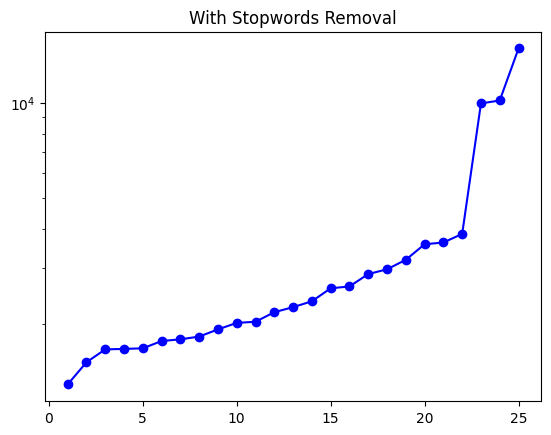

In [5]:
word_dict = {}
for i in range(len(preprocess_docs1.processed_documents)):
    for word in preprocess_docs1.word_freq_in_document[i]:
        if word not in word_dict:
            word_dict[word] = preprocess_docs1.word_freq_in_document[i][word]
        else:
            word_dict[word] += preprocess_docs1.word_freq_in_document[i][word]
frequencies = -1*np.array(sorted(word_dict.values()))
indices = np.arange(25)+1
plt.title('With Stopwords Removal')
plt.plot(indices, -frequencies[len(frequencies)-25: ], marker='o', color='b', linestyle='-')
plt.yscale('log')
print(dict(sorted(word_dict.items(), key = lambda x: x[1], reverse = True)[: 25]))

In [6]:
preprocess_docs2 = Preprocessing('documents.json')
preprocess_docs2.preprocess(remove_stopwords=False, perform_stemming=True)
tfidf_score2 = tfidfScore(preprocess_docs2)
tfidf_score2.tfidf()
tfidf_score2.tf_idf

[{'the': 0.003597112053756832,
  'most': 0.02387017156702138,
  'import': 0.04587784661724862,
  'step': 0.0785541855973004,
  'is': 0.0030882865993645684,
  'to': 0.004974860307927067,
  'find': 0.03465220146438913,
  'an': 0.014787281256779241,
  'insur': 0.008838299347467632,
  'agent': 0.02697163074146182,
  'who': 0.031761995623569184,
  'will': 0.01125592166992311,
  'listen': 0.08393374213501792,
  'you': 0.01820246157388704,
  'provid': 0.031165781479997424,
  'sound': 0.07340410489862369,
  'financi': 0.07599801021775858,
  'advic': 0.06316812541126846,
  'and': 0.011201688241535236,
  'commun': 0.06422855367593865,
  'clearli': 0.08069780856100196,
  'with': 0.012905853227852686,
  'compani': 0.03561438905060395,
  'pictur': 0.07913904092748823,
  'are': 0.008717901070162532,
  'invalu': 0.11940427056583906,
  'so': 0.025815679010274543,
  'photograph': 0.12312332975440922,
  'everyth': 0.06819271532100374,
  'own': 0.04118458617732564,
  'on': 0.013307888462183894,
  'a': 0.

{'the': 35477, 'to': 21567, 'you': 20917, 'a': 20865, 'of': 14950, 'insur': 14876, 'is': 14038, 'and': 13569, 'that': 11187, 'your': 10918, 'for': 10852, 'polici': 10179, 'life': 9963, 'in': 8769, 'be': 7935, 'are': 7390, 'it': 7258, 'if': 7241, 'have': 6331, 'or': 6117, 'can': 6041, 'will': 5889, 'with': 4993, 'not': 4824, 'as': 4653}


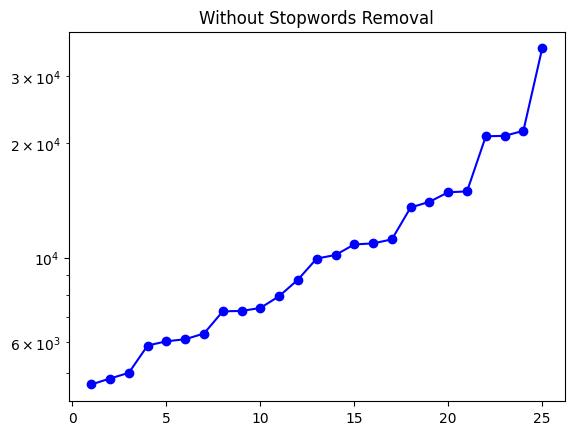

In [7]:
word_dict = {}
for i in range(len(preprocess_docs2.processed_documents)):
    for word in preprocess_docs2.word_freq_in_document[i]:
        if word not in word_dict:
            word_dict[word] = preprocess_docs2.word_freq_in_document[i][word]
        else:
            word_dict[word] += preprocess_docs2.word_freq_in_document[i][word]
frequencies = -1*np.array(sorted(word_dict.values()))
indices = np.arange(25)+1
plt.plot(indices, -frequencies[len(frequencies)-25: ], marker='o', color='b', linestyle='-')
plt.title('Without Stopwords Removal')
plt.yscale('log')
print(dict(sorted(word_dict.items(), key = lambda x: x[1], reverse = True)[: 25]))

In [8]:
preprocess_queries = Preprocessing('queries.json')
preprocess_queries.preprocess(remove_stopwords=False, perform_stemming=True)
tfidf_score_queries = tfidfScore(preprocess_queries)
tfidf_score_queries.tfidf()
tfidf_score_queries.tf_idf

[{'what': 0.1639976095059905,
  'is': 0.14453548641657465,
  'the': 0.2379771969329876,
  'cost': 0.3584231401826495,
  'of': 0.29240011432653373,
  'disabl': 0.3378971287160563,
  'insur': 0.007679582722825422,
  'for': 0.2265977518854243,
  'individu': 0.7068113863969995},
 {'doe': 0.19390802451821945,
  'life': 0.07055579701928458,
  'insur': 0.009873749215061256,
  'count': 0.8357824076867149,
  'in': 0.3597531919474,
  'net': 0.966681083668737,
  'worth': 0.688693919517978},
 {'can': 0.22885451596537792,
  'peopl': 0.6450679695820949,
  'with': 0.49322594014409055,
  'diabet': 0.8097364710018643,
  'get': 0.31612724201151693,
  'life': 0.07055579701928458,
  'insur': 0.009873749215061256},
 {'whi': 0.40085063086908307,
  'use': 0.6450679695820949,
  'an': 0.4856388222420979,
  'irrevoc': 0.8676600578744591,
  'life': 0.07055579701928458,
  'insur': 0.009873749215061256,
  'trust': 0.8097364710018643},
 {'which': 0.6243904499227995,
  'medicar': 0.6414994755994801,
  'plan': 0.6370

### 3.4 Probabilistic Model and LSI (Latent Semantic Indexing)

In [9]:
class ProbabilisticModel():
    def __init__(self, preprocess_docs, preprocess_queries, tfidf_docs, tfidf_queries, V, p):
        self.V = V
        self.preprocess_docs = preprocess_docs
        self.preprocess_queries = preprocess_queries
        self.tfidf_docs = tfidf_docs
        self.tfidf_queries = tfidf_queries
        self.similarities = np.zeros((len(self.preprocess_docs.processed_documents), len(self.preprocess_queries.processed_documents)), dtype=np.float64)
        self.probabilities_r = np.ones(len(self.preprocess_docs.word_index), dtype=np.float64)*0.5
        self.probabilities_nr = np.ones(len(self.preprocess_docs.word_index), dtype=np.float64)*0.5
        self.p = p
        self.p_stems = {}
        self.num_iters = 10



    def pMostOccuringStems(self):
        # for i, doc in enumerate(self.preprocess_docs.processed_documents):
        #     self.p_stems[i] = dict(sorted(self.preprocess_docs.word_freq_in_document[i].items(), key = lambda x: x[1], reverse = True)[: self.p])
        tokens = {}
        for i, doc in enumerate(self.preprocess_docs.processed_documents):
            for word in self.preprocess_docs.word_freq_in_document[i]:
                if (word not in tokens):    
                    tokens[word] = self.preprocess_docs.word_freq_in_document[i][word]
                else:
                    tokens[word] += self.preprocess_docs.word_freq_in_document[i][word]
        self.p_stems = dict(sorted(tokens.items(), key = lambda x: x[1], reverse = True)[: self.p])
        return



    def updateProbabilities(self, indices):
        for word in self.preprocess_docs.word_index:
            sum = 0
            for i in range(len(indices)):
                # if word in self.p_stems[indices[i]]:
                if word in self.p_stems:
                    sum += 1
            self.probabilities_r[self.preprocess_docs.word_index[word]] = (sum+0.5)/(self.V+1)
            self.probabilities_nr[self.preprocess_docs.word_index[word]] = (self.preprocess_docs.ni[word]-sum+0.5)/(len(self.preprocess_docs.processed_documents)-self.V+1)



    def similarity(self, document_index, query_index):
        sum = 0
        # for word in self.p_stems[document_index]:
        for word in self.p_stems:
            if (word not in self.tfidf_queries.tf_idf[query_index] or word not in self.tfidf_docs.tf_idf[document_index]):
                continue
            prob = self.probabilities_r[self.preprocess_docs.word_index[word]]
            prob1 = self.probabilities_nr[self.preprocess_docs.word_index[word]]
            sum += self.tfidf_docs.tf_idf[document_index][word]*self.tfidf_queries.tf_idf[query_index][word]*(np.log(prob/(1-prob))+np.log(((1-prob1)/prob1)))
        self.similarities[document_index][query_index] = sum


    
    def mostSimilarDocuments(self):
        for i in range(len(self.preprocess_docs.processed_documents)):
            for j in range(len(self.preprocess_queries.processed_documents)):
                self.similarity(i, j)
        
        for j in range(len(self.preprocess_queries.processed_documents)):
            l = []
            for x in range(len(self.similarities[:, j])):
                l.append(self.similarities[x, j])
            l1 = [[l[i], i] for i in range(len(l))]
            l2 = sorted(l1, reverse=True)[: self.V]
            indices = [l2[i][1] for i in range(len(l2))]
            self.updateProbabilities(indices)



    def iterativeRefinement(self):
        self.pMostOccuringStems()
        for i in range(self.num_iters):
            self.mostSimilarDocuments()

In [10]:
class LatentSemanticIndexing():
    def __init__(self, preprocess_docs, preprocess_queries, tfidf_docs, tfidf_queries, V, p):
        self.preprocess_docs = preprocess_docs
        self.preprocess_queries = preprocess_queries
        self.tfidf_docs = tfidf_docs
        self.tfidf_queries = tfidf_queries
        self.p = p
        self.k = 20
        self.V = V
        self.tfidfdoc_matrix = np.zeros((self.p, len(self.preprocess_docs.processed_documents)+len(self.preprocess_queries.processed_documents)))
        # self.tfidfquery_matrix = np.zeros((self.p, len(self.preprocess_queries.processed_docs)))



    def similarity(self, query_index):
        similarities = []
        for i in range(len(self.reduced_space[:, query_index])):
            similarities.append(self.reduced_space[i][query_index])
        l1 = [[similarities[i], i] for i in range(len(similarities))]
        l2 = sorted(l1, reverse=True)[: self.V]
        indices = [l2[i][1] for i in range(len(l2))]
        return indices




    def pMostOccuringStems(self):
        tokens = {}
        for i, doc in enumerate(self.preprocess_docs.processed_documents):
            for word in self.preprocess_docs.word_freq_in_document[i]:
                if (word not in tokens):    
                    tokens[word] = self.preprocess_docs.word_freq_in_document[i][word]
                else:
                    tokens[word] += self.preprocess_docs.word_freq_in_document[i][word]
        self.p_stems = dict(sorted(tokens.items(), key = lambda x: x[1], reverse = True)[: self.p])
        return
    


    def formTFIDFMatrix(self):
        for i in range(len(self.preprocess_docs.processed_documents)):
            for j, word in enumerate(self.p_stems):
                if word in self.preprocess_docs.word_freq_in_document[i]:
                    self.tfidfdoc_matrix[j][i] = self.preprocess_docs.word_freq_in_document[i][word]

        for i in range(len(self.preprocess_queries.processed_documents)):
            for j, word in enumerate(self.p_stems):
                if word in self.preprocess_queries.word_freq_in_document[i]:
                    self.tfidfdoc_matrix[j][i+len(self.preprocess_docs.processed_documents)] = self.preprocess_queries.word_freq_in_document[i][word]



    def factorise(self, mat):
        U, S, Vt = np.linalg.svd(mat, full_matrices=False)
        S_k = np.diag(S[: self.k])
        U_k = U[:, :self.k]
        Vt_k = Vt[:self.k, :]
        M_k = np.dot(U_k, np.dot(S_k, Vt_k))
        return M_k
    


    def fit(self):
        self.pMostOccuringStems()
        self.formTFIDFMatrix()
        # self.formQueryTFIDFMatrix()
        self.reduced_space = self.factorise(self.tfidfdoc_matrix)

In [9]:
probabilistic_model = ProbabilisticModel(preprocess_docs=preprocess_docs1, preprocess_queries=preprocess_queries, tfidf_docs=tfidf_score1, tfidf_queries=tfidf_score_queries, V=15, p=25)

In [10]:
probabilistic_model.iterativeRefinement()

In [11]:
for j in range(len(preprocess_queries.processed_documents)):
    l = []
    for x in range(len(probabilistic_model.similarities[:, j])):
        l.append(probabilistic_model.similarities[x, j])
    l1 = [[l[i], i] for i in range(len(l))]
    l2 = sorted(l1, reverse=True)[: probabilistic_model.V]
    indices = [l2[i][1] for i in range(len(l2))]
    print(f"For Query No. {j}, {probabilistic_model.V} most relevant documents are: ", indices)

For Query No. 0, 15 most relevant documents are:  [3573, 1896, 2749, 5946, 6167, 1688, 4409, 1407, 4910, 2237, 1941, 5823, 1753, 126, 5041]
For Query No. 1, 15 most relevant documents are:  [3283, 269, 4750, 2491, 5533, 4227, 2400, 5407, 3129, 3998, 1378, 4297, 6082, 2399, 4614]
For Query No. 2, 15 most relevant documents are:  [3283, 269, 4750, 2491, 5533, 4227, 2400, 5407, 3129, 3998, 1378, 4297, 6082, 2399, 4614]
For Query No. 3, 15 most relevant documents are:  [3283, 269, 4750, 2491, 5533, 4227, 2400, 5407, 3129, 3998, 1378, 4297, 6082, 2399, 4614]
For Query No. 4, 15 most relevant documents are:  [5480, 762, 2680, 1002, 4981, 3608, 761, 1020, 4983, 163, 4339, 2688, 2139, 2546, 2520]
For Query No. 5, 15 most relevant documents are:  [3283, 269, 4750, 2491, 5533, 4227, 2400, 5407, 3129, 3998, 1378, 4297, 6082, 2399, 4614]
For Query No. 6, 15 most relevant documents are:  [3177, 2434, 4727, 2437, 5418, 410, 995, 4108, 2165, 1038, 3231, 5128, 4646, 4079, 2301]
For Query No. 7, 15 mos

In [12]:
probabilistic_model = ProbabilisticModel(preprocess_docs=preprocess_docs2, preprocess_queries=preprocess_queries, tfidf_docs=tfidf_score2, tfidf_queries=tfidf_score_queries, V=15, p=25)

In [13]:
probabilistic_model.iterativeRefinement()

In [14]:
for j in range(len(preprocess_queries.processed_documents)):
    l = []
    for x in range(len(probabilistic_model.similarities[:, j])):
        l.append(probabilistic_model.similarities[x, j])
    l1 = [[l[i], i] for i in range(len(l))]
    l2 = sorted(l1, reverse=True)[: probabilistic_model.V]
    indices = [l2[i][1] for i in range(len(l2))]
    print(f"For Query No. {j}, {probabilistic_model.V} most relevant documents are: ", indices)

For Query No. 0, 15 most relevant documents are:  [209, 427, 5912, 905, 840, 1135, 6020, 4115, 5523, 2713, 2368, 897, 4732, 4238, 2198]
For Query No. 1, 15 most relevant documents are:  [1729, 800, 4816, 3970, 752, 798, 1305, 1066, 4914, 5273, 5169, 1829, 1359, 1730, 5171]
For Query No. 2, 15 most relevant documents are:  [4734, 1425, 1194, 1874, 4295, 281, 5002, 3301, 6282, 1395, 40, 736, 2281, 97, 1417]
For Query No. 3, 15 most relevant documents are:  [2491, 3283, 5533, 6082, 4237, 5407, 2400, 5467, 4750, 6162, 2399, 1378, 837, 5271, 5169]
For Query No. 4, 15 most relevant documents are:  [427, 1036, 4966, 4734, 3897, 1665, 1414, 4969, 3603, 634, 4820, 5698, 2183, 4109, 5937]
For Query No. 5, 15 most relevant documents are:  [427, 2491, 3283, 1036, 4734, 4614, 5533, 1378, 6082, 4733, 5467, 2400, 2399, 4237, 5002]
For Query No. 6, 15 most relevant documents are:  [1038, 3470, 5273, 4115, 69, 2966, 663, 1515, 5469, 2205, 1313, 598, 4042, 1872, 3845]
For Query No. 7, 15 most relevant d

In [15]:
lsi_model = LatentSemanticIndexing(preprocess_docs=preprocess_docs1, preprocess_queries=preprocess_queries, tfidf_docs=tfidf_score1, tfidf_queries=tfidf_score_queries, V=15, p=25)
lsi_model.fit()

In [16]:
for i in range(len(preprocess_queries.processed_documents)):
    print(lsi_model.similarity(i))

[0, 3, 22, 16, 23, 12, 20, 9, 19, 11, 24, 5, 15, 17, 1]
[0, 23, 16, 21, 12, 20, 9, 24, 19, 22, 11, 18, 5, 1, 14]
[23, 0, 5, 21, 7, 12, 8, 20, 24, 18, 19, 9, 16, 11, 22]
[16, 21, 3, 17, 20, 19, 22, 18, 6, 1, 14, 8, 2, 5, 0]
[3, 5, 8, 0, 18, 20, 17, 23, 13, 22, 15, 10, 7, 14, 9]
[3, 5, 0, 17, 12, 23, 14, 7, 9, 19, 10, 22, 4, 20, 2]
[0, 5, 1, 3, 17, 23, 9, 13, 7, 4, 10, 14, 2, 8, 15]
[3, 0, 5, 1, 17, 23, 9, 14, 7, 12, 20, 10, 19, 22, 4]
[0, 3, 6, 8, 9, 17, 18, 16, 20, 19, 22, 21, 14, 1, 10]
[10, 1, 4, 3, 8, 7, 24, 20, 12, 9, 15, 11, 17, 0, 5]
[1, 5, 23, 12, 24, 18, 19, 11, 16, 9, 20, 0, 22, 3, 15]
[1, 4, 0, 5, 2, 10, 14, 24, 17, 20, 15, 3, 9, 13, 23]
[1, 5, 0, 2, 18, 8, 4, 7, 14, 22, 19, 17, 24, 20, 23]
[5, 3, 0, 1, 2, 4, 18, 17, 20, 13, 21, 22, 19, 8, 16]
[0, 13, 12, 10, 18, 20, 17, 24, 9, 11, 15, 22, 5, 7, 19]
[1, 2, 10, 0, 4, 12, 24, 13, 23, 17, 8, 21, 3, 15, 20]
[5, 3, 2, 0, 18, 20, 17, 23, 13, 15, 9, 22, 8, 10, 7]
[11, 13, 12, 20, 9, 19, 22, 14, 5, 7, 1, 0, 4, 18, 16]
[11, 13, 23, 20

In [17]:
lsi_model = LatentSemanticIndexing(preprocess_docs=preprocess_docs2, preprocess_queries=preprocess_queries, tfidf_docs=tfidf_score2, tfidf_queries=tfidf_score_queries, V=15, p=25)
lsi_model.fit()

In [18]:
for i in range(len(preprocess_queries.processed_documents)):
    print(lsi_model.similarity(i))

[0, 2, 5, 7, 1, 3, 24, 15, 16, 9, 6, 4, 13, 22, 8]
[2, 1, 9, 10, 0, 14, 4, 13, 5, 3, 15, 20, 7, 8, 6]
[0, 7, 3, 1, 4, 2, 13, 5, 9, 18, 21, 10, 22, 6, 16]
[3, 6, 0, 9, 10, 17, 2, 7, 8, 19, 18, 1, 23, 16, 14]
[4, 21, 7, 3, 1, 18, 2, 24, 10, 0, 8, 5, 15, 14, 22]
[3, 0, 4, 15, 2, 17, 9, 16, 5, 13, 1, 8, 21, 23, 19]
[0, 2, 9, 21, 3, 1, 7, 4, 5, 14, 17, 18, 10, 11, 6]
[0, 3, 13, 2, 1, 9, 5, 10, 21, 16, 6, 18, 7, 8, 17]
[0, 2, 1, 9, 7, 16, 6, 13, 10, 8, 3, 4, 21, 5, 17]
[2, 10, 3, 1, 11, 7, 15, 0, 6, 13, 17, 21, 18, 9, 16]
[0, 11, 1, 2, 14, 17, 7, 8, 10, 13, 4, 15, 18, 19, 21]
[2, 11, 3, 9, 1, 13, 18, 7, 4, 20, 22, 12, 0, 5, 16]
[2, 11, 0, 3, 20, 1, 24, 16, 15, 17, 14, 5, 9, 19, 10]
[2, 1, 0, 6, 7, 10, 8, 5, 21, 4, 15, 16, 9, 12, 14]
[2, 0, 1, 4, 15, 14, 21, 5, 7, 3, 17, 13, 10, 6, 9]
[1, 2, 11, 0, 12, 4, 9, 18, 16, 8, 6, 13, 7, 3, 17]
[2, 1, 3, 9, 13, 0, 18, 8, 12, 4, 10, 5, 20, 22, 19]
[0, 1, 3, 13, 15, 2, 4, 7, 8, 20, 19, 18, 22, 24, 17]
[9, 2, 0, 8, 7, 1, 4, 6, 3, 17, 19, 15, 18, 22, 21]


### 3.5 Experimentation with different Updating Rules

In [11]:
probabilistic_model = ProbabilisticModel(preprocess_docs=preprocess_docs1, preprocess_queries=preprocess_queries, tfidf_docs=tfidf_score1, tfidf_queries=tfidf_score_queries, V=15, p=15)
probabilistic_model.iterativeRefinement()

In [12]:
for j in range(len(preprocess_queries.processed_documents)):
    l = []
    for x in range(len(probabilistic_model.similarities[:, j])):
        l.append(probabilistic_model.similarities[x, j])
    l1 = [[l[i], i] for i in range(len(l))]
    l2 = sorted(l1, reverse=True)[: probabilistic_model.V]
    indices = [l2[i][1] for i in range(len(l2))]
    print(f"For Query No. {j}, {probabilistic_model.V} most relevant documents are: ", indices)

For Query No. 0, 15 most relevant documents are:  [4733, 4734, 800, 4732, 2071, 2420, 1127, 1036, 3696, 2513, 4750, 5252, 4217, 798, 1186]
For Query No. 1, 15 most relevant documents are:  [3283, 269, 4750, 2491, 5533, 4227, 2400, 5407, 3129, 3998, 1378, 4297, 6082, 2399, 4614]
For Query No. 2, 15 most relevant documents are:  [3283, 269, 4750, 2491, 5533, 4227, 2400, 5407, 3129, 3998, 1378, 4297, 6082, 2399, 4614]
For Query No. 3, 15 most relevant documents are:  [3283, 269, 4750, 2491, 5533, 4227, 2400, 5407, 3129, 3998, 1378, 4297, 6082, 2399, 4614]
For Query No. 4, 15 most relevant documents are:  [5480, 762, 2680, 1002, 4981, 3608, 761, 1020, 4983, 163, 4339, 2688, 2139, 2546, 2520]
For Query No. 5, 15 most relevant documents are:  [3283, 269, 4750, 2491, 5533, 4227, 2400, 5407, 3129, 3998, 1378, 4297, 6082, 2399, 4614]
For Query No. 6, 15 most relevant documents are:  [4727, 3177, 2434, 5418, 995, 2437, 2165, 1038, 410, 2301, 5128, 2504, 5023, 4108, 139]
For Query No. 7, 15 most 

In [13]:
probabilistic_model = ProbabilisticModel(preprocess_docs=preprocess_docs2, preprocess_queries=preprocess_queries, tfidf_docs=tfidf_score2, tfidf_queries=tfidf_score_queries, V=15, p=15)
probabilistic_model.iterativeRefinement()

In [14]:
for j in range(len(preprocess_queries.processed_documents)):
    l = []
    for x in range(len(probabilistic_model.similarities[:, j])):
        l.append(probabilistic_model.similarities[x, j])
    l1 = [[l[i], i] for i in range(len(l))]
    l2 = sorted(l1, reverse=True)[: probabilistic_model.V]
    indices = [l2[i][1] for i in range(len(l2))]
    print(f"For Query No. {j}, {probabilistic_model.V} most relevant documents are: ", indices)

For Query No. 0, 15 most relevant documents are:  [209, 427, 5912, 905, 840, 1135, 6020, 4115, 5523, 2713, 2368, 897, 4732, 4238, 2198]
For Query No. 1, 15 most relevant documents are:  [1729, 800, 4816, 3970, 752, 798, 1305, 1066, 4914, 5273, 5169, 1829, 1359, 1730, 5171]
For Query No. 2, 15 most relevant documents are:  [2491, 3283, 5533, 6082, 4237, 5407, 2400, 5467, 4750, 6162, 2399, 1378, 837, 5271, 5169]
For Query No. 3, 15 most relevant documents are:  [2491, 3283, 5533, 6082, 4237, 5407, 2400, 5467, 4750, 6162, 2399, 1378, 837, 5271, 5169]
For Query No. 4, 15 most relevant documents are:  [427, 1036, 4966, 4734, 3897, 1665, 1414, 4969, 3603, 634, 4820, 5698, 2183, 4109, 5937]
For Query No. 5, 15 most relevant documents are:  [427, 2491, 3283, 1036, 4734, 4614, 5533, 1378, 6082, 4733, 5467, 2400, 2399, 4237, 5002]
For Query No. 6, 15 most relevant documents are:  [1038, 3470, 5273, 4115, 69, 2966, 663, 1515, 5469, 2205, 1313, 598, 4042, 1872, 3845]
For Query No. 7, 15 most relev

In [15]:
lsi_model = LatentSemanticIndexing(preprocess_docs=preprocess_docs1, preprocess_queries=preprocess_queries, tfidf_docs=tfidf_score1, tfidf_queries=tfidf_score_queries, V=15, p=15)
lsi_model.fit()
for i in range(len(preprocess_queries.processed_documents)):
    print(lsi_model.similarity(i))

[0, 3, 4, 8, 5, 13, 6, 14, 7, 12, 10, 9, 11, 2, 1]
[0, 2, 5, 7, 12, 13, 8, 1, 4, 3, 9, 14, 10, 6, 11]
[0, 5, 7, 8, 2, 4, 12, 10, 1, 13, 14, 6, 11, 3, 9]
[3, 14, 12, 8, 0, 1, 10, 13, 5, 7, 2, 4, 9, 11, 6]
[3, 5, 0, 8, 1, 10, 7, 13, 14, 11, 9, 12, 4, 2, 6]
[3, 0, 5, 14, 1, 12, 2, 4, 8, 13, 10, 11, 9, 6, 7]
[0, 5, 3, 1, 9, 11, 13, 6, 4, 12, 2, 14, 7, 10, 8]
[3, 0, 1, 5, 8, 9, 6, 4, 2, 14, 10, 13, 11, 12, 7]
[0, 3, 8, 9, 6, 1, 10, 2, 4, 7, 12, 5, 14, 11, 13]
[10, 4, 1, 8, 3, 7, 14, 13, 12, 6, 11, 9, 5, 2, 0]
[1, 5, 10, 14, 11, 12, 13, 9, 8, 3, 7, 6, 4, 2, 0]
[1, 4, 14, 5, 10, 2, 0, 12, 9, 3, 7, 8, 6, 13, 11]
[1, 5, 2, 0, 14, 8, 7, 4, 13, 11, 9, 10, 12, 3, 6]
[5, 0, 3, 1, 4, 2, 11, 9, 10, 7, 14, 6, 12, 13, 8]
[0, 13, 12, 10, 2, 1, 3, 8, 7, 6, 4, 9, 5, 11, 14]
[1, 2, 10, 12, 4, 0, 11, 13, 14, 8, 5, 9, 7, 6, 3]
[5, 3, 0, 2, 1, 11, 9, 14, 13, 4, 7, 10, 6, 12, 8]
[11, 13, 7, 14, 6, 5, 2, 3, 10, 9, 8, 1, 12, 4, 0]
[11, 5, 7, 14, 2, 6, 10, 3, 9, 8, 1, 4, 13, 12, 0]
[11, 3, 7, 14, 6, 5, 10, 8, 9, 

In [16]:
lsi_model = LatentSemanticIndexing(preprocess_docs=preprocess_docs2, preprocess_queries=preprocess_queries, tfidf_docs=tfidf_score2, tfidf_queries=tfidf_score_queries, V=15, p=15)
lsi_model.fit()
for i in range(len(preprocess_queries.processed_documents)):
    print(lsi_model.similarity(i))

[0, 2, 1, 5, 7, 3, 4, 9, 6, 13, 8, 11, 12, 10, 14]
[2, 9, 1, 10, 14, 0, 3, 13, 4, 5, 7, 8, 6, 12, 11]
[0, 3, 7, 1, 4, 2, 5, 13, 9, 6, 10, 8, 11, 14, 12]
[3, 6, 10, 9, 0, 8, 7, 2, 1, 14, 4, 11, 13, 5, 12]
[4, 7, 3, 1, 8, 2, 10, 0, 5, 11, 6, 12, 14, 13, 9]
[3, 0, 4, 13, 2, 1, 8, 9, 5, 7, 10, 6, 11, 14, 12]
[0, 9, 2, 3, 14, 7, 5, 1, 4, 10, 11, 6, 8, 12, 13]
[0, 3, 13, 2, 9, 1, 10, 5, 8, 6, 7, 11, 14, 4, 12]
[0, 2, 1, 9, 7, 6, 13, 3, 4, 10, 8, 5, 14, 12, 11]
[2, 10, 3, 1, 11, 7, 13, 6, 0, 9, 4, 14, 12, 8, 5]
[0, 11, 1, 10, 4, 2, 8, 14, 13, 7, 3, 9, 6, 5, 12]
[2, 9, 3, 11, 13, 1, 7, 4, 5, 12, 0, 10, 8, 14, 6]
[2, 11, 3, 0, 1, 14, 9, 10, 4, 5, 7, 12, 13, 8, 6]
[1, 2, 6, 7, 0, 10, 8, 4, 5, 9, 12, 11, 3, 14, 13]
[2, 0, 4, 1, 14, 7, 5, 3, 9, 10, 6, 13, 11, 12, 8]
[1, 2, 11, 0, 12, 9, 4, 8, 3, 13, 6, 7, 14, 10, 5]
[2, 9, 3, 1, 13, 0, 8, 10, 12, 5, 4, 11, 7, 14, 6]
[0, 1, 3, 13, 2, 4, 7, 8, 11, 5, 6, 10, 9, 12, 14]
[9, 2, 0, 8, 7, 3, 1, 6, 4, 10, 13, 14, 12, 11, 5]
[1, 14, 9, 13, 8, 2, 0, 7, 3, 4

In [17]:
probabilistic_model = ProbabilisticModel(preprocess_docs=preprocess_docs1, preprocess_queries=preprocess_queries, tfidf_docs=tfidf_score1, tfidf_queries=tfidf_score_queries, V=20, p=25)
probabilistic_model.iterativeRefinement()

In [18]:
for j in range(len(preprocess_queries.processed_documents)):
    l = []
    for x in range(len(probabilistic_model.similarities[:, j])):
        l.append(probabilistic_model.similarities[x, j])
    l1 = [[l[i], i] for i in range(len(l))]
    l2 = sorted(l1, reverse=True)[: probabilistic_model.V]
    indices = [l2[i][1] for i in range(len(l2))]
    print(f"For Query No. {j}, {probabilistic_model.V} most relevant documents are: ", indices)

For Query No. 0, 20 most relevant documents are:  [3573, 1896, 2749, 5946, 6167, 1688, 4409, 1407, 4910, 2237, 1941, 5823, 1753, 126, 5041, 3566, 2151, 1695, 4373, 1895]
For Query No. 1, 20 most relevant documents are:  [3283, 269, 4750, 2491, 5533, 4227, 2400, 5407, 3129, 3998, 1378, 4297, 6082, 2399, 4614, 837, 4237, 5002, 4734, 2624]
For Query No. 2, 20 most relevant documents are:  [3283, 269, 4750, 2491, 5533, 4227, 2400, 5407, 3129, 3998, 1378, 4297, 6082, 2399, 4614, 837, 4237, 5002, 4734, 2624]
For Query No. 3, 20 most relevant documents are:  [3283, 269, 4750, 2491, 5533, 4227, 2400, 5407, 3129, 3998, 1378, 4297, 6082, 2399, 4614, 837, 4237, 5002, 4734, 2624]
For Query No. 4, 20 most relevant documents are:  [5480, 762, 2680, 1002, 4981, 3608, 761, 1020, 4983, 163, 4339, 2688, 2139, 2546, 2520, 237, 5845, 2547, 184, 4338]
For Query No. 5, 20 most relevant documents are:  [3283, 269, 4750, 2491, 5533, 4227, 2400, 5407, 3129, 3998, 1378, 4297, 6082, 2399, 4614, 837, 4237, 5002, 

In [19]:
probabilistic_model = ProbabilisticModel(preprocess_docs=preprocess_docs2, preprocess_queries=preprocess_queries, tfidf_docs=tfidf_score2, tfidf_queries=tfidf_score_queries, V=20, p=25)
probabilistic_model.iterativeRefinement()

In [20]:
for j in range(len(preprocess_queries.processed_documents)):
    l = []
    for x in range(len(probabilistic_model.similarities[:, j])):
        l.append(probabilistic_model.similarities[x, j])
    l1 = [[l[i], i] for i in range(len(l))]
    l2 = sorted(l1, reverse=True)[: probabilistic_model.V]
    indices = [l2[i][1] for i in range(len(l2))]
    print(f"For Query No. {j}, {probabilistic_model.V} most relevant documents are: ", indices)

For Query No. 0, 20 most relevant documents are:  [209, 427, 5912, 905, 1135, 840, 6020, 4115, 5523, 2713, 897, 4732, 2368, 2198, 4238, 6370, 5407, 2127, 1830, 518]
For Query No. 1, 20 most relevant documents are:  [1729, 800, 4816, 3970, 752, 798, 1305, 1066, 4914, 5273, 5169, 1829, 1359, 1730, 5171, 1832, 5492, 4982, 4661, 1249]
For Query No. 2, 20 most relevant documents are:  [4734, 1425, 1194, 1874, 4295, 281, 5002, 3301, 6282, 1395, 40, 736, 2281, 97, 1417, 6183, 1778, 3165, 3447, 124]
For Query No. 3, 20 most relevant documents are:  [2491, 3283, 5533, 6082, 4237, 5407, 2400, 5467, 4750, 6162, 2399, 1378, 837, 5271, 5169, 1829, 2395, 5158, 4227, 3129]
For Query No. 4, 20 most relevant documents are:  [427, 1036, 4966, 4734, 3897, 1665, 1414, 4969, 3603, 634, 4820, 5698, 2183, 4109, 5937, 1668, 3584, 5418, 5555, 6320]
For Query No. 5, 20 most relevant documents are:  [427, 2491, 3283, 1036, 4734, 4614, 5533, 1378, 4733, 6082, 5467, 2400, 2399, 5002, 3998, 4237, 4297, 4667, 5271, 

In [21]:
lsi_model = LatentSemanticIndexing(preprocess_docs=preprocess_docs1, preprocess_queries=preprocess_queries, tfidf_docs=tfidf_score1, tfidf_queries=tfidf_score_queries, V=20, p=25)
lsi_model.fit()
for i in range(len(preprocess_queries.processed_documents)):
    print(lsi_model.similarity(i))

[0, 3, 22, 16, 23, 12, 20, 9, 19, 11, 24, 5, 15, 17, 1, 7, 14, 4, 2, 18]
[0, 23, 16, 21, 12, 20, 9, 24, 19, 22, 11, 18, 5, 1, 14, 15, 3, 7, 4, 2]
[23, 0, 5, 21, 7, 12, 8, 20, 24, 18, 19, 9, 16, 11, 22, 1, 14, 3, 15, 4]
[16, 21, 3, 17, 20, 19, 22, 18, 6, 1, 14, 8, 2, 5, 0, 9, 10, 12, 13, 11]
[3, 5, 8, 0, 18, 20, 17, 23, 13, 22, 15, 10, 7, 14, 9, 2, 1, 4, 11, 6]
[3, 5, 0, 17, 12, 23, 14, 7, 9, 19, 10, 22, 4, 20, 2, 11, 1, 15, 16, 8]
[0, 5, 1, 3, 17, 23, 9, 13, 7, 4, 10, 14, 2, 8, 15, 19, 18, 11, 21, 16]
[3, 0, 5, 1, 17, 23, 9, 14, 7, 12, 20, 10, 19, 22, 4, 2, 11, 15, 8, 16]
[0, 3, 6, 8, 9, 17, 18, 16, 20, 19, 22, 21, 14, 1, 10, 2, 5, 12, 13, 11]
[10, 1, 4, 3, 8, 7, 24, 20, 12, 9, 15, 11, 17, 0, 5, 21, 2, 22, 16, 19]
[1, 5, 23, 12, 24, 18, 19, 11, 16, 9, 20, 0, 22, 3, 15, 4, 21, 14, 7, 2]
[1, 4, 0, 5, 2, 10, 14, 24, 17, 20, 15, 3, 9, 13, 23, 8, 11, 21, 6, 12]
[1, 5, 0, 2, 18, 8, 4, 7, 14, 22, 19, 17, 24, 20, 23, 13, 15, 3, 11, 21]
[5, 3, 0, 1, 2, 4, 18, 17, 20, 13, 21, 22, 19, 8, 16, 9, 6

In [22]:
lsi_model = LatentSemanticIndexing(preprocess_docs=preprocess_docs2, preprocess_queries=preprocess_queries, tfidf_docs=tfidf_score2, tfidf_queries=tfidf_score_queries, V=20, p=25)
lsi_model.fit()
for i in range(len(preprocess_queries.processed_documents)):
    print(lsi_model.similarity(i))

[0, 2, 5, 7, 1, 3, 24, 15, 16, 9, 6, 4, 13, 22, 8, 20, 21, 18, 14, 23]
[2, 1, 9, 10, 0, 14, 4, 13, 5, 3, 15, 20, 7, 8, 6, 17, 21, 22, 19, 23]
[0, 7, 3, 1, 4, 2, 13, 5, 9, 18, 21, 10, 22, 6, 16, 17, 24, 19, 8, 20]
[3, 6, 0, 9, 10, 17, 2, 7, 8, 19, 18, 1, 23, 16, 14, 4, 20, 22, 15, 21]
[4, 21, 7, 3, 1, 18, 2, 24, 10, 0, 8, 5, 15, 14, 22, 23, 12, 9, 11, 16]
[3, 0, 4, 15, 2, 17, 9, 16, 5, 13, 1, 8, 21, 23, 19, 14, 12, 7, 22, 18]
[0, 2, 9, 21, 3, 1, 7, 4, 5, 14, 17, 18, 10, 11, 6, 22, 24, 19, 23, 8]
[0, 3, 13, 2, 1, 9, 5, 10, 21, 16, 6, 18, 7, 8, 17, 24, 23, 11, 22, 19]
[0, 2, 1, 9, 7, 16, 6, 13, 10, 8, 3, 4, 21, 5, 17, 15, 22, 14, 24, 18]
[2, 10, 3, 1, 11, 7, 15, 0, 6, 13, 17, 21, 18, 9, 16, 4, 22, 24, 23, 20]
[0, 11, 1, 2, 14, 17, 7, 8, 10, 13, 4, 15, 18, 19, 21, 23, 20, 22, 12, 16]
[2, 11, 3, 9, 1, 13, 18, 7, 4, 20, 22, 12, 0, 5, 16, 17, 24, 19, 8, 23]
[2, 11, 0, 3, 20, 1, 24, 16, 15, 17, 14, 5, 9, 19, 10, 12, 4, 7, 18, 23]
[2, 1, 0, 6, 7, 10, 8, 5, 21, 4, 15, 16, 9, 12, 14, 3, 11, 24, 1

### 3.6 Transformer-Based Model

6. **Without applying the Porter stemmer or stop word removal**, use the all-MiniLM-L6-v2 model to encode both the queries and the documents. Find the similarity between the encoded vectors and rank the documents based on this similarity. Compare these rankings with the results from the probabilistic and LSI models.

In [19]:
from sentence_transformers import SentenceTransformer
import numpy as np

class TransformerModel():
    def __init__(self):
        self.model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
        
    def encode_text(self, text_list):
        embeddings = self.model.encode(text_list, convert_to_tensor=True)
        return embeddings

    def calculate_similarity(self, query_embeddings, doc_embeddings):   
        similarities = cosine_similarity(query_embeddings, doc_embeddings)
        return similarities

    def rank_documents(self, similarities):
        ranked_indices = np.argsort(similarities, axis=1)[:, ::-1]
        l = ranked_indices[0][: 15]
        return l

In [20]:
preprocess = Preprocessing(file_path='documents.json')
preprocess.preprocess(remove_stopwords=False, perform_stemming=False)

transformer = TransformerModel()
doc_embeddings = transformer.encode_text(preprocess.processed_documents)

# query = "your search query"
for i in range(len(preprocess_queries.processed_documents)):
    query_embedding = transformer.encode_text([preprocess_queries.processed_documents[i]])
    similarities = transformer.calculate_similarity(query_embedding, doc_embeddings)
    ranked_indices = transformer.rank_documents(similarities)
    print(f"For Query = {i}, 15 most relevant documents are: ", end = "")
    for j in range(len(ranked_indices)):
        print(ranked_indices[j], end = " ")
    print()

For Query = 0, 15 most relevant documents are: 5893 1433 6191 1685 4966 6292 4121 3878 2078 1957 3375 2519 3847 3235 5196 
For Query = 1, 15 most relevant documents are: 4025 971 5509 4118 2164 6431 2583 1412 4670 4734 278 1655 3642 1656 539 
For Query = 2, 15 most relevant documents are: 202 2679 735 2296 6300 3325 2295 1162 672 6158 6159 3544 3661 3694 2084 
For Query = 3, 15 most relevant documents are: 330 6131 4229 2536 3903 530 4640 4657 2665 4434 3909 4183 4131 2281 985 
For Query = 4, 15 most relevant documents are: 341 3747 2701 5721 3355 5741 5976 5742 2784 3356 3357 6102 5491 1542 3835 
For Query = 5, 15 most relevant documents are: 6191 1685 3878 2078 6292 4121 3375 4966 1433 2519 3900 3847 3805 4467 3235 
For Query = 6, 15 most relevant documents are: 2856 628 3549 1011 2624 3816 3607 203 746 4835 3292 6078 3294 5929 6031 
For Query = 7, 15 most relevant documents are: 985 3473 3984 4663 122 5177 3689 3085 3475 3809 6378 3646 2315 2680 3921 
For Query = 8, 15 most relevant